In [1]:
import json
with open('prompt1.json', 'r') as file:
    openai_resp = json.load(file)

In [2]:
import pandas as pd
openai_resp=pd.DataFrame(openai_resp)

In [3]:
openai_resp["label"].value_counts()

label
false                             377
partly true/misleading            249
true                              205
mostly true                        71
mostly false                       51
complicated/hard to categorise     24
other                              14
Name: count, dtype: int64

In [4]:
openai_resp

,openai_resp,index,label,language
0,50,0,false,tr
1,50,1,partly true/misleading,ka
2,50,2,partly true/misleading,pt
3,50,3,true,ka
4,50,4,false,id
...,...,...,...,...
995,85,995,partly true/misleading,ar
996,0,996,partly true/misleading,ta
997,50,997,false,pt
998,100,998,complicated/hard to categorise,pt


#Simplify labels
(partly true is assumed false)

In [5]:
#remove other and complicated labels 
openai_resp = openai_resp[~openai_resp['label'].isin(['complicated/hard to categorise', 'other'])]


In [6]:
#simplify the truth-value to binary, so we can approximate some accuracy by delineating false as anything below 50
def simplify_truth(row):
    if row['label'] in ['false', 'mostly false','partly true/misleading']: 
        return 0
    else:
        return 1
    
openai_resp['simple_truth'] = openai_resp.apply(simplify_truth, axis=1)

openai_resp["simple_truth"].value_counts() 

/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_24484/813761942.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openai_resp['simple_truth'] = openai_resp.apply(simplify_truth, axis=1)


simple_truth
0    677
1    285
Name: count, dtype: int64

#Convert the prompt 1 scores to binary

In [7]:
#Remove responses which couldn't evaluate to a score
anomalies=[]
def catch_anomalies(row):
   if len(row["openai_resp"])>4:
      anomalies.append(row)
      
   else:
      return row  # Returning the row unchanged

openai_resp = openai_resp.apply(catch_anomalies, axis=1).dropna()

#Convert the score to binary hard classification >=50 implies true
def convert_Score(row):
    if (int(row["openai_resp"])>=50):
      return 1
    else:
      return 0
openai_resp['simple_score'] = openai_resp.apply(convert_Score, axis=1)


In [8]:
print(anomalies)

[openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         0
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         0
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         0
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         0
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleadin

In [9]:
len(anomalies)

10

Hence there are 10 entries where ChatGpt couldn't evaluate a score

In [10]:
openai_resp

,openai_resp,index,label,language,simple_truth,simple_score
0,50,0.0,false,tr,0.0,1
1,50,1.0,partly true/misleading,ka,0.0,1
2,50,2.0,partly true/misleading,pt,0.0,1
3,50,3.0,true,ka,1.0,1
4,50,4.0,false,id,0.0,1
...,...,...,...,...,...,...
994,50,994.0,true,ro,1.0,1
995,85,995.0,partly true/misleading,ar,0.0,1
996,0,996.0,partly true/misleading,ta,0.0,0
997,50,997.0,false,pt,0.0,1


#Overall data accuracy score

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(openai_resp["simple_truth"], openai_resp["simple_score"], normalize=True)

0.38918345705196183

#Overall data micro f1 score

In [12]:
from sklearn.metrics import f1_score
f1_score(openai_resp["simple_truth"], openai_resp["simple_score"], average='micro')

0.38918345705196183

In [13]:
openai_resp_grouped=pd.DataFrame(openai_resp).groupby("language")

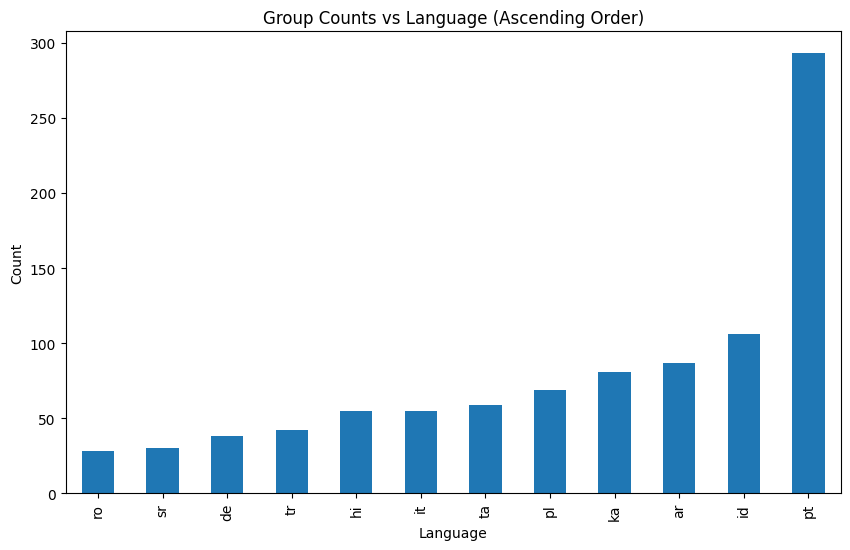

In [14]:
import matplotlib.pyplot as plt
group_counts = openai_resp_grouped.size()

# Sort the groups based on the counts in ascending order
sorted_group_counts = group_counts.sort_values()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sorted_group_counts.plot(kind='bar')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Group Counts vs Language (Ascending Order)')
plt.show()

In [15]:
def calculate_metrics(group):
    accuracy = accuracy_score(group["simple_truth"], group["simple_score"],normalize=True)
    f1 = f1_score(group["simple_truth"], group["simple_score"],average='micro')
    count = len(group)
    return pd.Series({'accuracy': accuracy, 'f1': f1, 'count': count})

# Apply the custom function to each group and construct a new DataFrame
metrics_df = openai_resp_grouped.apply(calculate_metrics).reset_index()

/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_24484/3303902291.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = openai_resp_grouped.apply(calculate_metrics).reset_index()


In [16]:
print(metrics_df)

   language  accuracy        f1  count
0        ar  0.195402  0.195402   87.0
1        de  0.421053  0.421053   38.0
2        hi  0.163636  0.163636   55.0
3        id  0.245283  0.245283  106.0
4        it  0.490909  0.490909   55.0
5        ka  0.543210  0.543210   81.0
6        pl  0.652174  0.652174   69.0
7        pt  0.426621  0.426621  293.0
8        ro  0.250000  0.250000   28.0
9        sr  0.133333  0.133333   30.0
10       ta  0.457627  0.457627   59.0
11       tr  0.476190  0.476190   42.0


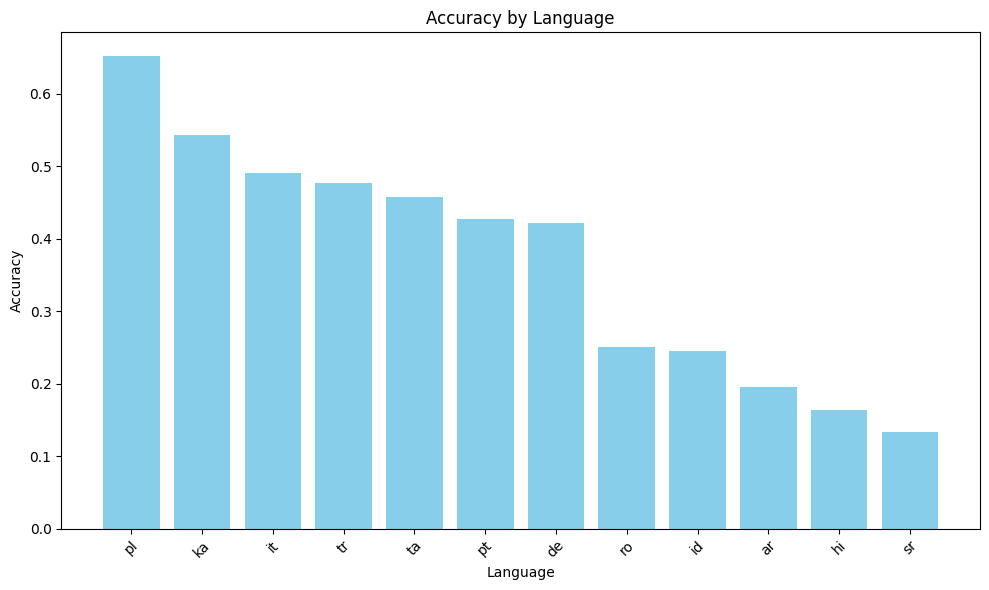

In [17]:
import matplotlib.pyplot as plt


# Sort the data by accuracy in descending order for better visualization
data_sorted = metrics_df.sort_values(by='accuracy', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(data_sorted['language'], data_sorted['accuracy'], color='skyblue')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


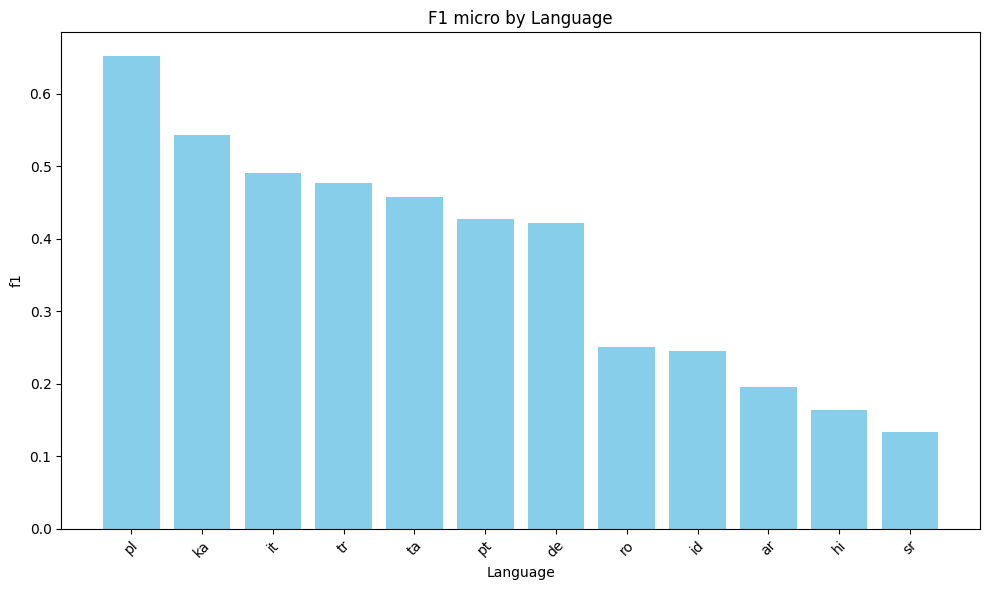

In [18]:
import matplotlib.pyplot as plt


# Sort the data by accuracy in descending order for better visualization
data_sorted = metrics_df.sort_values(by='f1', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(data_sorted['language'], data_sorted['f1'], color='skyblue')
plt.xlabel('Language')
plt.ylabel('f1')
plt.title('F1 micro by Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

European vs non european languages

In [19]:
def euro_or_not(lang):
    if lang in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]:
        return "European"
    else:
        return "Non-european"

# Apply the euro_or_not function to create a new column 'euro_language'
openai_resp['euro_language'] = openai_resp['language'].apply(euro_or_not)

# Group the DataFrame based on the 'euro_language' column
grouped_euro = openai_resp.groupby('euro_language')

In [20]:
# Apply the custom function to each group and construct a new DataFrame
metrics_df_euro = grouped_euro.apply(calculate_metrics).reset_index()

/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_24484/3067288616.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_euro = grouped_euro.apply(calculate_metrics).reset_index()


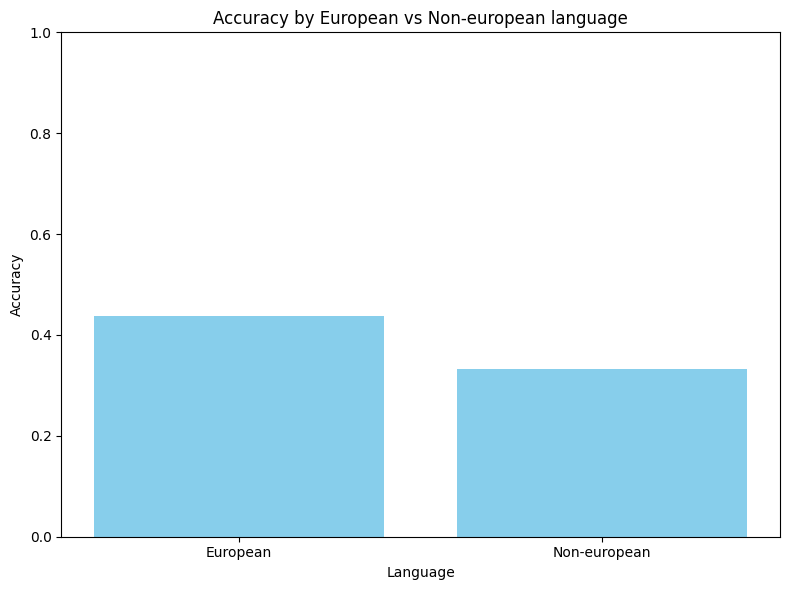

In [21]:
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics_df_euro['euro_language'], metrics_df_euro['accuracy'], color='skyblue')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by European vs Non-european language')
plt.ylim(0, 1)  
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
print(metrics_df_euro)

  euro_language  accuracy        f1  count
0      European  0.436647  0.436647  513.0
1  Non-european  0.332558  0.332558  430.0


Western vs Non-western languages

In [23]:
def western(lang):
    if lang in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return "Western"
    else:
        return "Non-western"

In [24]:
# Apply the western function to create a new column 'western_language'
openai_resp['western_language'] = openai_resp['language'].apply(western)

# Group the DataFrame based on the 'western_language' column
grouped_western = openai_resp.groupby('western_language')
# Apply the custom function to each group and construct a new DataFrame
metrics_df_western = grouped_western.apply(calculate_metrics).reset_index()
print(metrics_df_western)

  western_language  accuracy        f1  count
0      Non-western  0.357271  0.357271  557.0
1          Western  0.435233  0.435233  386.0


/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_24484/2685116895.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_western = grouped_western.apply(calculate_metrics).reset_index()


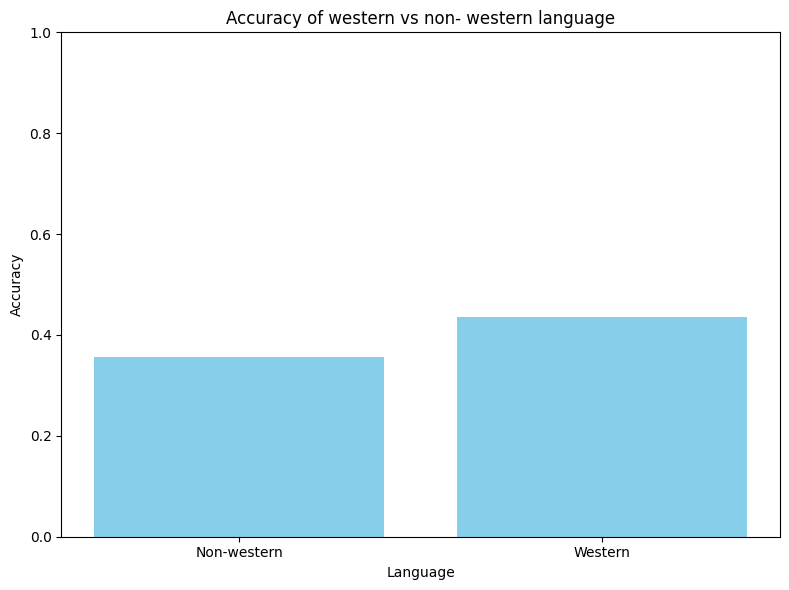

In [25]:
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics_df_western['western_language'], metrics_df_western['accuracy'], color='skyblue')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy of western vs non- western language')
plt.ylim(0, 1)  
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Language classification based on number of speakers(Small, Big)

In [26]:
#languages by size (https://en.wikipedia.org/wiki/List_of_languages_by_total_number_of_speakers)
#<45 m: no, nl, pl, ro, sr, sq, az, ka, si
#>45 m: de, es, fr, it, pt, ru, ar, bn, fa, gu, hi, id, mr, pa, ta, tr
def small(lang):
    if lang in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return "Small"
    else:
        return "Big"


In [27]:
# Apply the small function to create a new column 'small_language'
openai_resp['small_language'] = openai_resp['language'].apply(small)

# Group the DataFrame based on the 'small_language' column
grouped_small = openai_resp.groupby('small_language')
# Apply the custom function to each group and construct a new DataFrame
metrics_df_small = grouped_small.apply(calculate_metrics).reset_index()
print(metrics_df_small)

  small_language  accuracy        f1  count
0            Big  0.363265  0.363265  735.0
1          Small  0.480769  0.480769  208.0


/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_24484/1686398616.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_small = grouped_small.apply(calculate_metrics).reset_index()


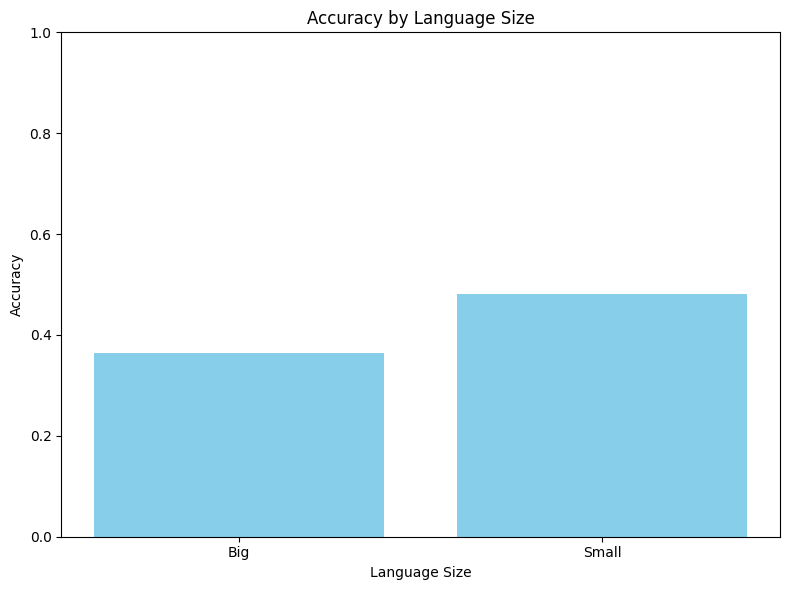

In [28]:
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics_df_small['small_language'], metrics_df_small['accuracy'], color='skyblue')
plt.xlabel('Language Size')
plt.ylabel('Accuracy')
plt.title('Accuracy by Language Size')
plt.ylim(0, 1)  
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
